In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import os
import os.path as osp
import sys
import time
import cv2
from lxml import etree
from tqdm import tqdm, tnrange, tqdm_notebook
from collections import OrderedDict
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch import Tensor
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split

import torchvision
from torchvision import datasets, models

from draw import show_img
from utils import bbox_x1y1x2y2_to_xywh, bbox_x1y1x2y2_to_cxcywh, bbox_cxcywh_to_x1y1x2y2, bbox_cxcywh_to_xywh
import transforms

# Utils

In [2]:
def getImgGrid(img_list, cols=2):
    num_img, height, width, channel = img_list.shape
    rows = num_img // cols
    # target = (height * rows, width * cols, channel)
    grid = img_list.reshape(rows, cols, height, width, channel)\
                    .transpose(0, 2, 1, 3, 4)\
                    .reshape(height * rows, width * cols, channel)
    return grid

# Load image with openCV

In [3]:
from imgaug import augmenters as iaa
import numpy as np
label_xml_path = './custom_data/7_x_wing.xml'
img_path = './output/x_wing_0391.jpg'
img_path = './custom_data/x_wing/x_wing_0384.jpg'

(<matplotlib.axes._subplots.AxesSubplot at 0x7f2c63d11550>, (546, 1280, 3))

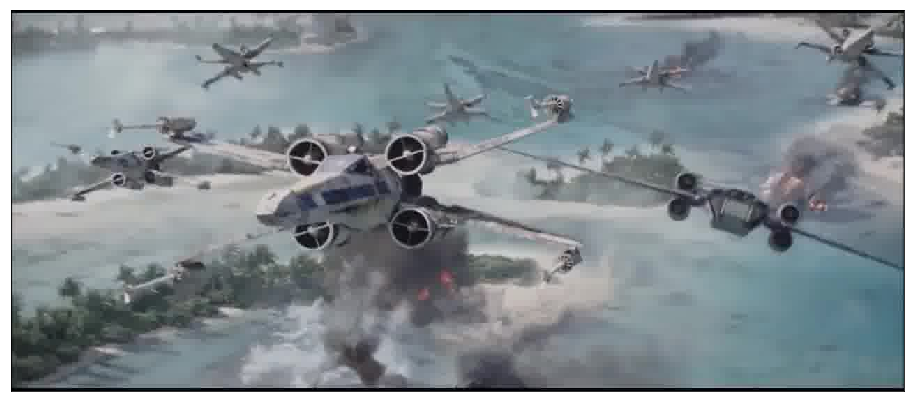

In [4]:
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
show_img(img,  figsize=(16,8)), img.shape

# Imaug library

## First example : Simple code to add Gaussian Noise

(<matplotlib.axes._subplots.AxesSubplot at 0x7f2c63d06710>, (546, 1280, 3))

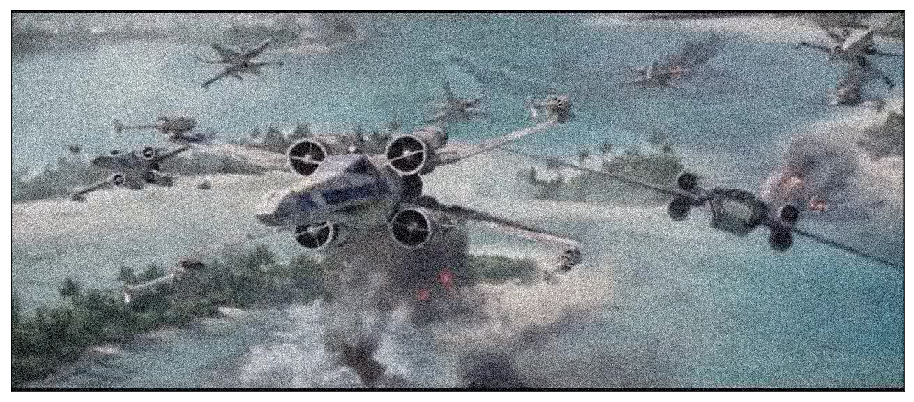

In [5]:
seq = iaa.Sequential([iaa.AdditiveGaussianNoise(scale=0.1*255)])
aug_img = seq.augment_images([img])[0]
show_img(aug_img,  figsize=(16,8)), img.shape

## List of augmentations we are going to use

In [6]:
aug_list = [iaa.GaussianBlur((3.0)),
            iaa.AverageBlur(k=(11)),
            iaa.MedianBlur(k=(11)),
            iaa.Sharpen(alpha=(0, 0.5), lightness=(0.75, 1.5)),
            iaa.AdditiveGaussianNoise(loc=0, scale=(0.05*255), per_channel=0.5),
            iaa.Add((-20, 20), per_channel=0.5),
            iaa.Multiply((0.8, 1.2), per_channel=0.5),
            iaa.ContrastNormalization((4), per_channel=0.5)
        ]
seq_list = [iaa.Sequential([aug]) for aug in aug_list]
img_list = np.array([img for _ in range(len(seq_list))])
aug_img_list = np.array([seq.augment_images([img])[0] for seq, img in zip(seq_list, img_list)])

(<matplotlib.axes._subplots.AxesSubplot at 0x7f2c63cadb70>, (2184, 2560, 3))

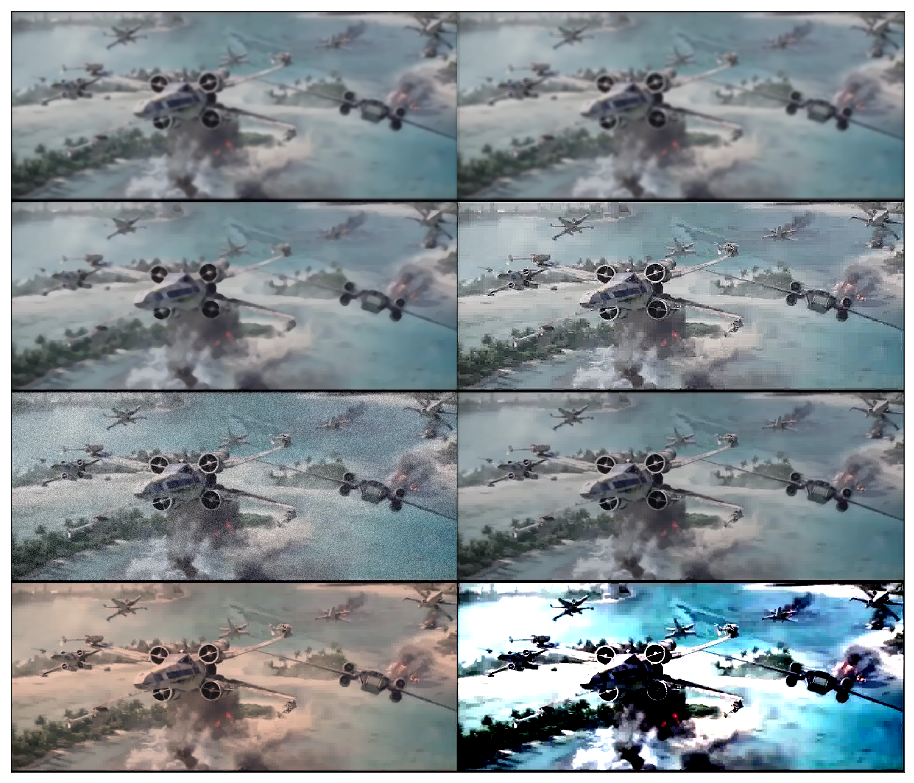

In [7]:
result = getImgGrid(aug_img_list, 2)
show_img(result,  figsize=(16,16)), result.shape

## Augmentation sequence for our datasets

In [8]:
# Code copied from official Imaug doc and parameters taken from https://github.com/BobLiu20/YOLOv3_PyTorch

class BasicAugmentations():
    def __init__(self):
        # Sometimes(0.5, ...) applies the given augmenter in 50% of all cases,
        sometimes = lambda aug: iaa.Sometimes(0.5, aug)
        self.seq = iaa.Sequential(
            [
                # Blur each image with varying strength using
                # gaussian blur (sigma between 0 and 3.0),
                # average/uniform blur (kernel size between 2x2 and 7x7)
                # median blur (kernel size between 3x3 and 11x11).
                iaa.OneOf([
                    iaa.GaussianBlur((0, 3.0)),
                    iaa.AverageBlur(k=(2, 7)),
                    iaa.MedianBlur(k=(3, 11)),
                ]),
                # Sharpen each image, overlay the result with the original
                # image using an alpha between 0 (no sharpening) and 1
                # (full sharpening effect).
                sometimes(iaa.Sharpen(alpha=(0, 0.5), lightness=(0.75, 1.5))),
                # Add gaussian noise to some images.
                # In 50% of these cases, the noise is randomly sampled per
                # channel and pixel.
                # In the other 50% of all cases it is sampled once per
                # pixel (i.e. brightness change).
                sometimes(iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5)),
                # Add a value of -5 to 5 to each pixel.
                sometimes(iaa.Add((-5, 5), per_channel=0.5)),
                # Change brightness of images (80-120% of original value).
                sometimes(iaa.Multiply((0.8, 1.2), per_channel=0.5)),
                # Improve or worsen the contrast of images.
                sometimes(iaa.ContrastNormalization((0.5, 2.0), per_channel=0.5))
            ],
            # do all of the above augmentations in random order
            random_order=True
        )

    def __call__(self, sample):
        seq_det = self.seq.to_deterministic()
        img, label = sample['img'], sample['label']
        img = seq_det.augment_images([img])[0]
        sample.update({'img': img, 'label': label})
        return sample

# Letterbox transforms (Revisit)

## Image

In [9]:
"""Returns the new dimension, padding and ratio required to perform a keep-aspect ratio resize
    Args:
        org_w, org_h: width and height of the original image
        new_w, new_h: width and height of the target image
"""
def letterbox_transforms(org_w, org_h, new_w, new_h):
    ratio = min(new_w / org_w, new_h / org_h)
    resize_w, resize_h = int(org_w * ratio), int(org_h * ratio)
    x_off, y_off = (new_w - resize_w) // 2, (new_h - resize_h) // 2
    return resize_w, resize_h, x_off, y_off, ratio

In [10]:
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


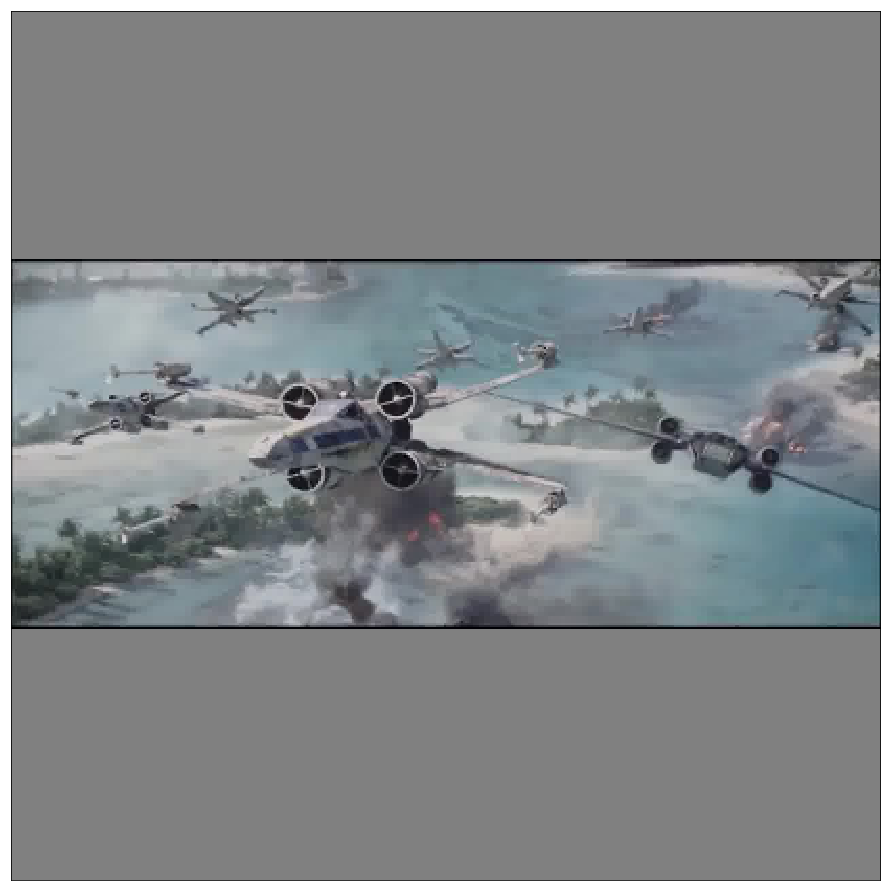

In [11]:
new_dim = (416, 416)
org_w, org_h = img.shape[1], img.shape[0]
new_w, new_h = new_dim[1], new_dim[0]
resize_w, resize_h, x_off, y_off, ratio = letterbox_transforms(org_w, org_h, new_w, new_h)
resize_img = cv2.resize(img, (resize_w, resize_h), interpolation = cv2.INTER_CUBIC)

#Put the box image on top of the blank image
letterbox_img = np.full(new_dim +(3,), 128)
letterbox_img[y_off:y_off+resize_h, x_off:x_off+resize_w] = resize_img
show_img(letterbox_img,  figsize=(16,16))

## Labels

In [12]:
# Sample labels for './custom_data/x_wing/x_wing_0384.jpg'
label = np.array([[   0.  ,  870.84,   66.63,  975.61,  129.49],
                  [   0.  , 1122.01,    0.  , 1276.65,  116.92],
                  [   0.  ,  587.54,  104.35,  695.67,  172.24],
                  [   0.  ,   57.83,  176.43,  290.  ,  279.52],
                  [   0.  ,  150.45,  117.76,  824.74,  427.46],
                  [   0.  ,  256.47,   28.92,  396.45,  123.63]])
img_dim = img.shape[1], img.shape[0]
label, img_dim

(array([[   0.  ,  870.84,   66.63,  975.61,  129.49],
        [   0.  , 1122.01,    0.  , 1276.65,  116.92],
        [   0.  ,  587.54,  104.35,  695.67,  172.24],
        [   0.  ,   57.83,  176.43,  290.  ,  279.52],
        [   0.  ,  150.45,  117.76,  824.74,  427.46],
        [   0.  ,  256.47,   28.92,  396.45,  123.63]]), (1280, 546))

In [13]:
label[..., 1:5] = bbox_x1y1x2y2_to_cxcywh(label[..., 1:5])
label

array([[   0.   ,  923.225,   98.06 ,  104.77 ,   62.86 ],
       [   0.   , 1199.33 ,   58.46 ,  154.64 ,  116.92 ],
       [   0.   ,  641.605,  138.295,  108.13 ,   67.89 ],
       [   0.   ,  173.915,  227.975,  232.17 ,  103.09 ],
       [   0.   ,  487.595,  272.61 ,  674.29 ,  309.7  ],
       [   0.   ,  326.46 ,   76.275,  139.98 ,   94.71 ]])

In [14]:
def letterbox_labels(labels, x_off, y_off, resize_dim, new_dim, bbs_idx=np.arange(0,4)):
    if isinstance(labels, torch.Tensor): 
        labels = labels.clone()
    elif isinstance(labels, np.ndarray):
        labels = labels.copy()
    else:
        raise TypeError("Labels must be a numpy array or pytorch tensor")
    ratio_x = resize_dim[0] / new_dim[0]
    ratio_y = resize_dim[1] / new_dim[1]
    x_idx, y_idx, cxw_idx, cyh_idx = bbs_idx[0], bbs_idx[1], bbs_idx[[0,2]], bbs_idx[[1,3]]    
    labels[..., cxw_idx] *= ratio_x 
    labels[..., cyh_idx] *= ratio_y 
    labels[..., x_idx] += x_off
    labels[..., y_idx] += y_off

    return labels

In [15]:
# Convert the coordinates from pixels to ratio format
bbs_idx = np.arange(1,5)
x_idx, y_idx = bbs_idx[[0,2]], bbs_idx[[1,3]] 
label[..., x_idx] = label[..., x_idx] / org_w
label[..., y_idx] = label[..., y_idx] / org_h
x_off, y_off = x_off / new_w, y_off / new_h
label

array([[0.        , 0.72126953, 0.17959707, 0.08185156, 0.11512821],
       [0.        , 0.93697656, 0.1070696 , 0.1208125 , 0.21413919],
       [0.        , 0.50125391, 0.25328755, 0.08447656, 0.12434066],
       [0.        , 0.13587109, 0.41753663, 0.18138281, 0.18880952],
       [0.        , 0.38093359, 0.49928571, 0.52678906, 0.56721612],
       [0.        , 0.25504688, 0.1396978 , 0.10935937, 0.17346154]])

In [16]:
label = letterbox_labels(label, x_off, y_off, (resize_w, resize_h), (new_w, new_h), bbs_idx)
label

array([[0.        , 0.72126953, 0.36247279, 0.08185156, 0.04898484],
       [0.        , 0.93697656, 0.33161375, 0.1208125 , 0.09111211],
       [0.        , 0.50125391, 0.39382667, 0.08447656, 0.05290456],
       [0.        , 0.13587109, 0.4637115 , 0.18138281, 0.08033482],
       [0.        , 0.38093359, 0.49849416, 0.52678906, 0.24133955],
       [0.        , 0.25504688, 0.34549642, 0.10935937, 0.07380455]])

In [17]:
def cv2_drawTextWithBkgd(img, text, bt_left_pt, color, max_x, max_y, font_scale=2.0, font=cv2.FONT_HERSHEY_PLAIN):
    (text_width, text_height) = cv2.getTextSize(text, cv2.FONT_HERSHEY_PLAIN, fontScale=font_scale, thickness=1)[0]
        
    t_pt1 = np.clip(bt_left_pt[0], 0, max_x - text_width), np.clip(bt_left_pt[1], text_height, max_y) 
    t_pt2 = t_pt1[0] + text_width, t_pt1[1] - text_height
    
    img = cv2.rectangle(img, t_pt1, t_pt2, color, cv2.FILLED, 4)
    img = cv2.putText(img, text, t_pt1, cv2.FONT_HERSHEY_PLAIN, fontScale=font_scale, color=(0, 0, 0), thickness=2);
    return img

In [18]:
def get_color_pallete(num_color):
    cmap = plt.get_cmap('tab20b')
    colors = np.array([cmap(i) for i in np.linspace(0, 1, num_color)])
    bbox_colors = colors[torch.randperm(num_color)]
    return bbox_colors

In [19]:
def draw_labels_on_image(img, labels, classes_names, bbox_colors, font_scale=0.7, font=cv2.FONT_HERSHEY_PLAIN):
    for l in labels:
        if l.sum() == 0:
            break;

        box_coord = l[1:5]
        cls = l[0]

        cls_text = classes_names[cls.int().item()]
        cls_color = bbox_colors[cls.int()]

        box_coord = bbox_cxcywh_to_x1y1x2y2(box_coord.clone())

        box_coord[[0,2]] = box_coord[[0,2]] * img.shape[1]
        box_coord[[1,3]] = box_coord[[1,3]] * img.shape[0]

        pt1 = tuple(box_coord[0:2].int().numpy())
        pt2 = tuple(box_coord[2:4].int().numpy())

        img = cv2.rectangle(img, pt1, pt2, cls_color, 4)
        img = cv2_drawTextWithBkgd(img, cls_text, pt1, cls_color, img.shape[1], img.shape[0], font_scale=font_scale, font=font)

    show_img(img, figsize=(16,8))

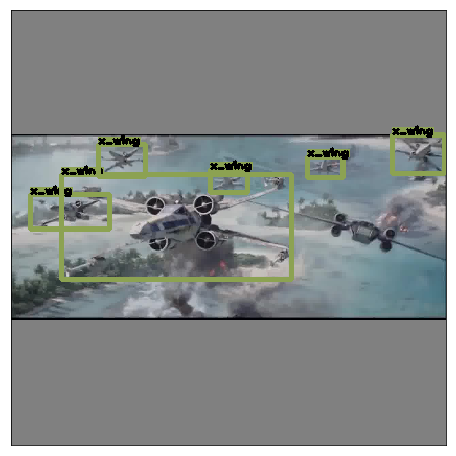

In [20]:
#We expect the output of the network to be torch.Tensors
draw_labels_on_image(letterbox_img / 255, torch.from_numpy(label), ['x_wing', 'tie'], get_color_pallete(20))

# Putting everything together to be used for datasets

**Compose a sequence of transformations**

In [21]:
class Compose():
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, sample):
        for t in self.transforms:
            sample = t(sample)
        return sample

** Convert input(numpy array) to torch.Tensor **

In [22]:
class ToTensor():
    def __init__(self, max_labels=50, max_label_cols=5):
        self.max_labels = max_labels
        self.max_label_cols = max_label_cols

    def __call__(self, sample):
        img, org_img, label = sample.get('img', None), sample.get('org_img', None), sample.get('label', None)

        img = torch.from_numpy(img).float().permute(2,0,1) / 255.0 if img is not None else None
        org_img = torch.from_numpy(org_img).float().permute(2,0,1) / 255.0 if org_img is not None else None
        label = torch.from_numpy(fill_label_np_tensor(label, self.max_labels, self.max_label_cols))

        sample.update({'img': img, 'org_img': org_img, 'label': label})
        return sample
    
def fill_label_np_tensor(label, row, col):
    label_tmp = np.full((row, col), 0.0)
    if label is not None:
        length = label.shape[0] if label.shape[0] < row else row
        label_tmp[:length] = label[:length]
    return label_tmp

** Augmentations on the image base before resizing **

In [23]:
class BasicAugmentations():
    def __init__(self):
        sometimes = lambda aug: iaa.Sometimes(0.5, aug)
        self.seq = iaa.Sequential(
            [
                # Blur each image with varying strength using
                # gaussian blur (sigma between 0 and 3.0),
                # average/uniform blur (kernel size between 2x2 and 7x7)
                # median blur (kernel size between 3x3 and 11x11).
                iaa.OneOf([
                    iaa.GaussianBlur((0, 3.0)),
                    iaa.AverageBlur(k=(2, 7)),
                    iaa.MedianBlur(k=(3, 11)),
                ]),
                # Sharpen each image, overlay the result with the original
                # image using an alpha between 0 (no sharpening) and 1
                # (full sharpening effect).
                sometimes(iaa.Sharpen(alpha=(0, 0.5), lightness=(0.75, 1.5))),
                # Add gaussian noise to some images.
                sometimes(iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5)),
                # Add a value of -5 to 5 to each pixel.
                sometimes(iaa.Add((-5, 5), per_channel=0.5)),
                # Change brightness of images (80-120% of original value).
                sometimes(iaa.Multiply((0.8, 1.2), per_channel=0.5)),
                # Improve or worsen the contrast of images.
                sometimes(iaa.ContrastNormalization((0.5, 2.0), per_channel=0.5))
            ],
            # do all of the above augmentations in random order
            random_order=True
        )

    def __call__(self, sample):
        seq_det = self.seq.to_deterministic()
        img, label = sample['img'], sample['label']
        img = seq_det.augment_images([img])[0]
        sample.update({'img': img, 'label': label})
        return sample

** Letterbox transform **

In [24]:
class Letterbox:
    """Letterbox image and labels
    Args:
        new_dim: target dimension (weight, height)
        box_coord_scale: Given (bx, bx, bw, bh) with image of (w, h)
                         'pixel' -- labels value are interpreted as pixels (bx, bx, bw, bh)
                         'ratio' -- labels value are interpreted as ratio (bx/w, bx/h, bw/w, bh/h)
    """
    def __init__(self, new_dim, box_coord_scale='ratio', bbs_idx=np.arange(0,4)):
        self.new_dim = new_dim
        self.box_coord_scale = box_coord_scale
        self.bbs_idx = bbs_idx
        
    def __call__(self, sample):
        org_img = sample['img']
        org_w, org_h = org_img.shape[1], org_img.shape[0]
        new_w, new_h = self.new_dim[1], self.new_dim[0]
        resize_w, resize_h, x_off, y_off, ratio = letterbox_transforms(org_w, org_h, new_w, new_h)
        resize_img = cv2.resize(org_img, (resize_w, resize_h), interpolation = cv2.INTER_CUBIC)
        
        #Put the box image on top of the blank image
        img = np.full(self.new_dim +(3,), 128)
        img[y_off:y_off+resize_h, x_off:x_off+resize_w] = resize_img
        
        labels = sample['label']
        if sample['label'] is not None:
            if self.box_coord_scale == 'pixel':
                x_idx, y_idx = self.bbs_idx[[0,2]], self.bbs_idx[[1,3]] 
                labels[..., x_idx] = labels[..., x_idx] / org_w
                labels[..., y_idx] = labels[..., y_idx] / org_h

        x_off, y_off = x_off / new_w, y_off / new_h

        if labels is not None:
            labels = letterbox_labels(labels, x_off, y_off, (resize_w, resize_h), (new_w, new_h), self.bbs_idx)

        transform = np.array([x_off, y_off, resize_w, resize_h,new_w, new_h])
        sample['img'], sample['label'], sample['transform'] = img, labels, transform
        return sample

** Simple function to construct frequently used augmentations sequence **

In [25]:
def getTransforms(dim, bbs_idx=np.arange(0,4), box_coord_scale='ratio', isTrain=True):
    if isTrain:
        transform = Compose([BasicAugmentations(),
                             Letterbox(dim, box_coord_scale=box_coord_scale, bbs_idx=bbs_idx),
                             ToTensor()])
    else:
        transform = Compose([Letterbox(dim, box_coord_scale=box_coord_scale, bbs_idx=bbs_idx),
                             ToTensor()])
    return transform

** Example **

In [26]:
label = np.array([ [0.        , 0.72126953, 0.17959707, 0.08185156, 0.11512821],
                   [0.        , 0.93697656, 0.1070696 , 0.1208125 , 0.21413919],
                   [0.        , 0.50125391, 0.25328755, 0.08447656, 0.12434066],
                   [0.        , 0.13587109, 0.41753663, 0.18138281, 0.18880952],
                   [0.        , 0.38093359, 0.49928571, 0.52678906, 0.56721612],
                   [0.        , 0.25504688, 0.1396978 , 0.10935937, 0.17346154]])
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
sample = {'img': img, 'label': label}
transform = getTransforms((416,416), np.arange(1,5), box_coord_scale='ratio', isTrain=True)

In [27]:
sample = transform(sample)

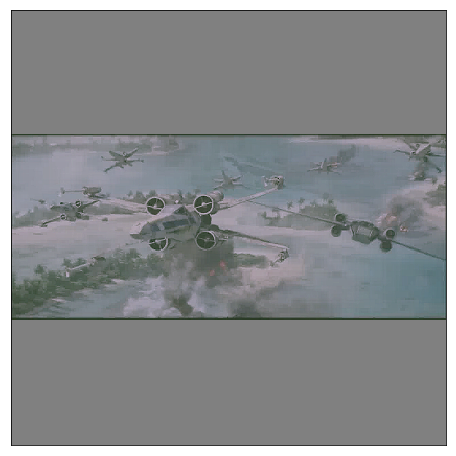

In [28]:
letterbox_img, letterbox_label = sample['img'], sample['label']
letterbox_img = np.ascontiguousarray(letterbox_img.numpy().transpose(1, 2, 0))
show_img(letterbox_img, figsize=(16,8))

In [29]:
def draw_labels_on_image(img, labels, classes_names, bbox_colors, font_scale=0.7, font=cv2.LINE_AA):
    for l in labels:
        if l.sum() == 0:
            break;

        box_coord = l[1:5]
        cls = l[0]

        cls_text = classes_names[cls.int().item()]
        cls_color = bbox_colors[cls.int()] 

        box_coord = bbox_cxcywh_to_x1y1x2y2(box_coord.clone())

        box_coord[[0,2]] = box_coord[[0,2]] * img.shape[1]
        box_coord[[1,3]] = box_coord[[1,3]] * img.shape[0]

        pt1 = tuple(box_coord[0:2].int())
        pt2 = tuple(box_coord[2:4].int())

        img = cv2.rectangle(img, pt1, pt2, cls_color, 4)
        img = cv2_drawTextWithBkgd(img, cls_text, pt1, cls_color, img.shape[1], img.shape[0], font_scale=font_scale, font=font)

    show_img(img, figsize=(16,8))

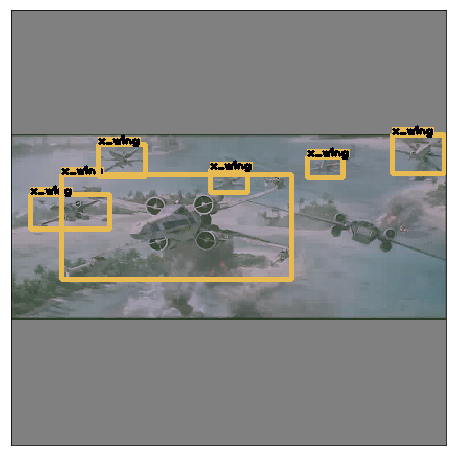

In [30]:
draw_labels_on_image(letterbox_img, letterbox_label, ['x_wing', 'tie'], get_color_pallete(20))

In [31]:
def letterbox_label_reverse(labels, x_off, y_off, resize_dim, new_dim, bbs_idx=np.arange(0,4)):
    if isinstance(labels, torch.Tensor):
        labels = labels.clone()
    elif isinstance(labels, np.ndarray):
        labels = labels.copy()
    else:
        raise TypeError("Labels must be a numpy array or pytorch tensor")
    ratio_x = resize_dim[0] / new_dim[0]
    ratio_y = resize_dim[1] / new_dim[1]
    x_idx, y_idx, cxw_idx, cyh_idx = bbs_idx[0], bbs_idx[1], bbs_idx[[0,2]], bbs_idx[[1,3]]  
    labels[..., x_idx] -= x_off
    labels[..., y_idx] -= y_off
    labels[..., cxw_idx] = np.clip((labels[..., cxw_idx] ) / ratio_x, 0, 1) 
    labels[..., cyh_idx] = np.clip((labels[..., cyh_idx] ) / ratio_y, 0, 1)
    return labels

In [32]:
transform = sample['transform']
x_off, y_off, resize_w, resize_h,new_w, new_h = (transform[i] for i in range(len(transform)))
letterbox_label[..., 1:5] = letterbox_label_reverse(letterbox_label[..., 1:5], x_off, y_off, (resize_w, resize_h), (new_w, new_h))

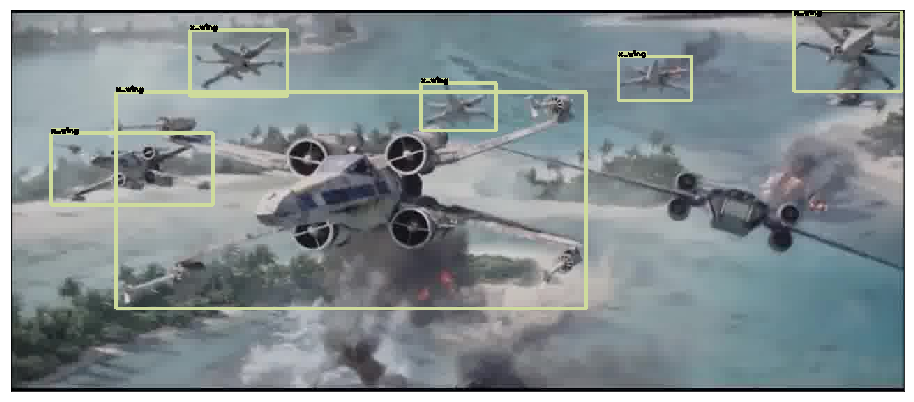

In [33]:
draw_labels_on_image(img / 255, letterbox_label, ['x_wing', 'tie'], get_color_pallete(20))